In [1]:
"""Setup"""

import numpy as np
import sys
#from google.colab import drive
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
from matplotlib.patches import Circle, Rectangle
from mpl_toolkits.mplot3d import Axes3D
from viz import *
from optics import *

#drive.mount("/content/gdrive")
np.set_printoptions(
    edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)
)
# the code in this notebook is formatted with Black https://black.vercel.app/ using 3.7, which is what this says:
print(sys.version)

3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]


"Relative Luminous Intensity" from the [Cree XP-E2 datasheet](https://cree-led.com/media/documents/XLampXPE2.pdf)

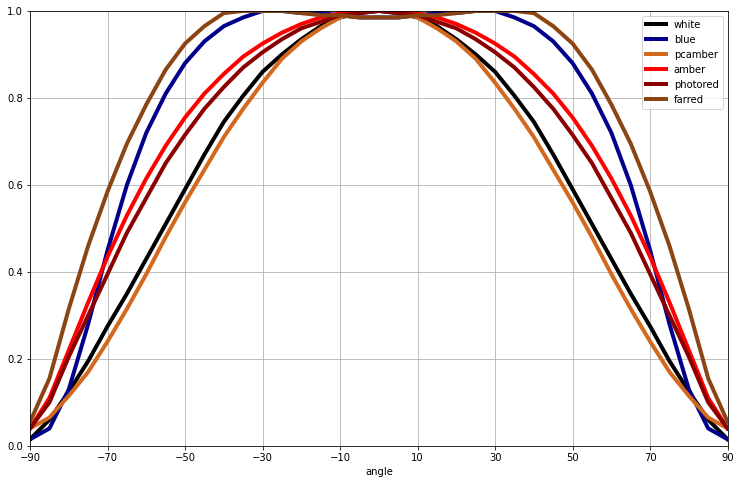

In [2]:
""" Show Cree XP-E2 data."""
import pandas as pd


def get_cree_data():
    # spatial-distribution.txt data is eyeballed from https://cree-led.com/media/documents/XLampXPE2.pdf, page 20.
    df = pd.read_csv(
#        "/content/gdrive/MyDrive/spatial-distribution.txt", delim_whitespace=True
        "spatial-distribution.txt", delim_whitespace=True
    )
    return df

def mirror(df):
    """ Mirror the data on the negative side of the angle scale, for visualization."""
    # The angle is the polar angle, so it is never negative, but it's common to visualize
    # on a [-90,90] scale.
    df2 = df.copy()
    df2["angle"] = df2["angle"] * -1
    df3 = pd.concat([df, df2])
    df3 = df3.sort_values(by=["angle"])
    return df3

def show_cree_data(df3):
    """ Duplicates the charts on page 20."""
    ax = df3.plot(
        x="angle",
        color=["black", "darkblue", "chocolate", "red", "darkred", "saddlebrown"],
        xlim=[-90, 90],
        ylim=[0, 1],
        grid=True,
        figsize=[12.5, 8],
        linewidth=4,
        xticks=[-90, -70, -50, -30, -10, 10, 30, 50, 70, 90],
    )


cree_spatial_distribution = get_cree_data()
cree_spatial_distribution_both_sides = mirror(cree_spatial_distribution)
show_cree_data(cree_spatial_distribution_both_sides)

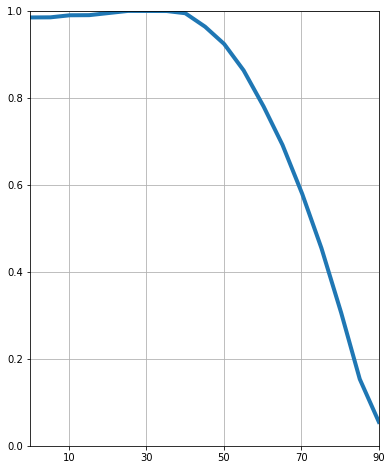

In [3]:
""" Show interpolated spatial distribution.

To use the Cree data above, I need a continuous version of it; try interp1d.
"""
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


def make_interpolated_spatial_distribution(cree_data):
    farred = interpolate.interp1d(cree_data["angle"], cree_data["farred"])
    x_new = np.arange(0, 90, 0.001)
    y_new = farred(x_new)
    return pd.DataFrame({"angle": x_new, "farred": y_new})


def show_interpolated_spatial_distribution(df_interp):
    plt.figure(figsize=[6.25, 8])
    ax = plt.subplot()
    plt.plot(df_interp["angle"], df_interp["farred"], "-", linewidth=4)
    ax.grid(True)
    ax.set_xlim(0, 90)
    ax.set_ylim(0, 1)
    ax.set_xticks([10, 30, 50, 70, 90])


cree_spatial_distribution_interpolated = make_interpolated_spatial_distribution(
    cree_spatial_distribution
)
show_interpolated_spatial_distribution(cree_spatial_distribution_interpolated)



Polar coordinates.  "Photo Red" is the most nearly Lambertian.

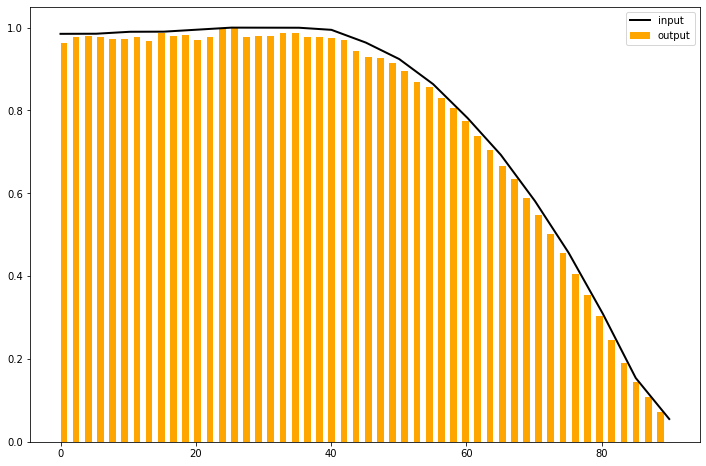

In [4]:
""" Show how to generate random numbers matching a given distribution.

Cribbed from https://stackoverflow.com/questions/17821458/random-number-from-histogram
"""

def generate_rand_from_pdf(pdf: pd.Series, x_grid: pd.Series) -> pd.Series:
    cdf = pdf.cumsum()
    cdf = cdf / cdf.iloc[-1]
    values = np.random.rand(1000000)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

def show_histogram_fit():
    given_x: pd.Series = cree_spatial_distribution_interpolated['angle']
    given_pdf: pd.Series = cree_spatial_distribution_interpolated['farred']
    random_from_cdf: pd.Series = generate_rand_from_pdf(given_pdf, given_x)

    f = plt.figure(figsize=[12,8])
    plt.plot(given_x, given_pdf, '-', linewidth=2, label='input', color='black')
    counts, bins = np.histogram(random_from_cdf, 50)
    plt.hist(bins[:-1], bins, weights=counts/counts.max(), color='orange', label='output', width=1)
    plt.legend();

show_histogram_fit()

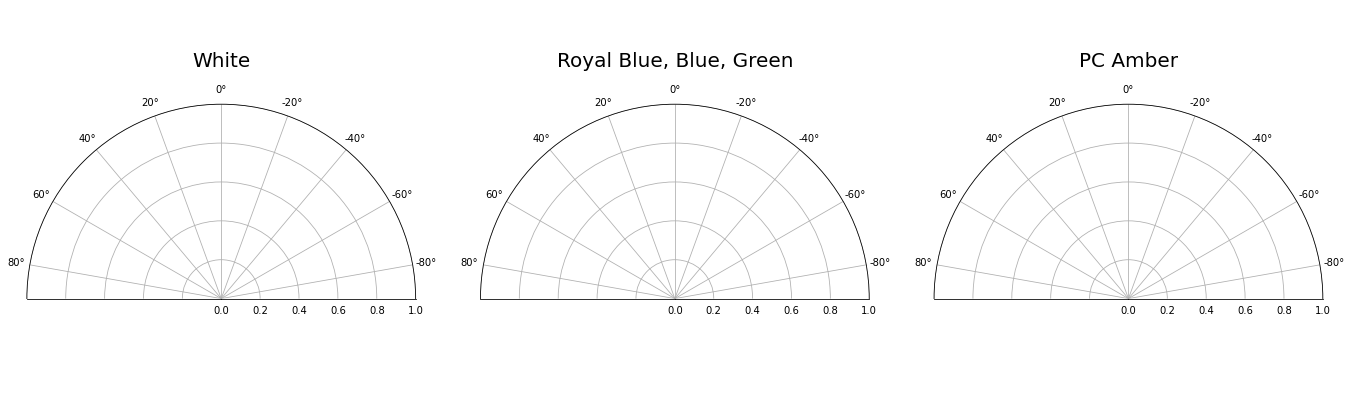

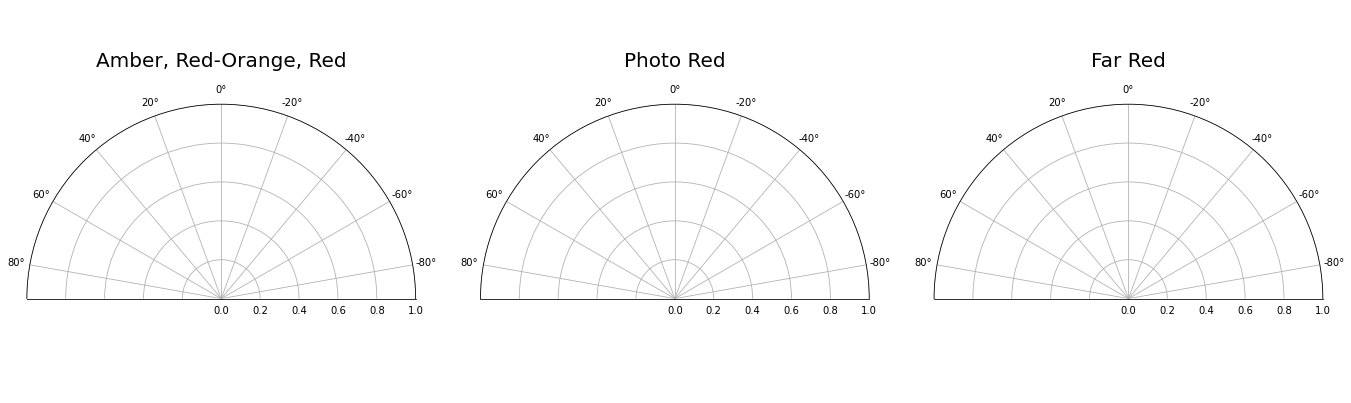

In [5]:
""" Show spatial distribution in polar coordinates."""
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.transforms import Bbox


def show_cree_data_polar(df3):
    df4 = df3.copy()
    df4["radians"] = df4["angle"] * np.pi / 180
    # there are two figures here because I couldn't figure out how to make the half-polar plots
    # the right size in a grid.
    titles = ["White", "Royal Blue, Blue, Green", "PC Amber"]
    columns = ["white", "blue", "pcamber"]
    positions = [131, 132, 133]
    subpositions = [
        [0.0, -0.6, 0.3, 1.4],
        [0.35, -0.6, 0.65, 1.4],
        [0.7, -0.6, 1.0, 1.4],
    ]
    f = plt.figure(figsize=[18, 3])
    for t, c, p, s in zip(titles, columns, positions, subpositions):
        ax = plt.subplot(p, polar=True)
        ax.set_theta_zero_location("N")
        ax.set_thetamin(-90)
        ax.set_thetamax(90)
        ax.set_title(t, pad=-60, fontsize=20)
        bb = Bbox.from_extents(s)
        ax.set_position(bb)
        plt.polar(df4["radians"], df4[c])
        ax.set_rmax(1.0)

    titles = ["Amber, Red-Orange, Red", "Photo Red", "Far Red"]
    columns = ["amber", "photored", "farred"]

    f = plt.figure(figsize=[18, 3])
    for t, c, p, s in zip(titles, columns, positions, subpositions):
        ax = plt.subplot(p, polar=True)
        ax.set_theta_zero_location("N")
        ax.set_thetamin(-90)
        ax.set_thetamax(90)
        ax.set_title(t, pad=-60, fontsize=20)
        bb = Bbox.from_extents(s)
        ax.set_position(bb)
        plt.polar(df4["radians"], df4[c])
        ax.set_rmax(1.0)


show_cree_data_polar(cree_spatial_distribution_both_sides)


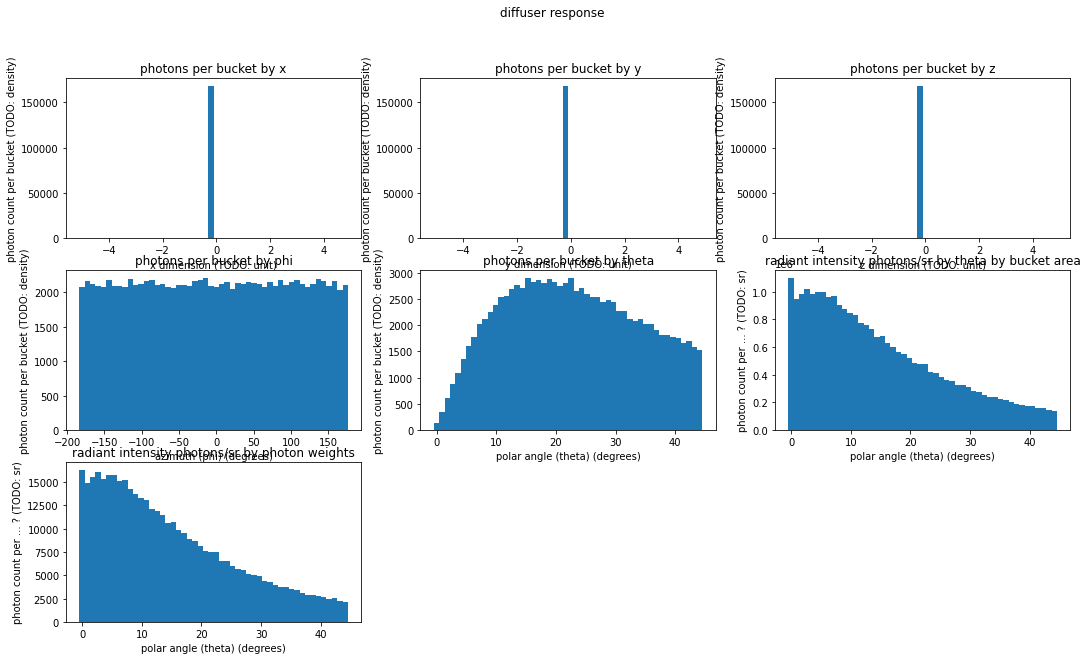

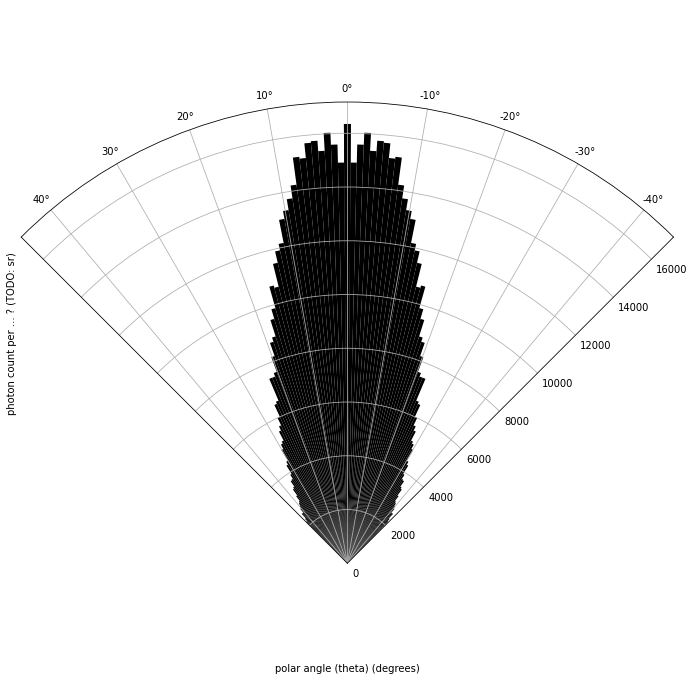

In [6]:
""" Show the intensity plot for the diffuser.

The plan is to use Acrylite 0D010DF in the 0.118 thickness, available at Tap plastics.
It is described here:
https://www.acrylite.co/files/content/acrylite.co/documents/product-information/satinice/ACRYLITE-Satinice-Enhanced-Acrylic.pdf
as producing 40-degree FWHM scattering. 
"""
def verify_diffuser():
    photons = PencilSource().make_photons(200000) # pretty high resolution
    diffuser = Diffuser(g = 0.64, absorption = 0.16) # from datasheet
    diffuser.diffuse(photons)
    plot_histogram_slices(photons, "diffuser response", x_min=-5, x_max=5, y_min=-5, y_max=5, z_min=-5, z_max=5, theta_min=0, theta_max=np.pi/4, bins=50)

verify_diffuser()


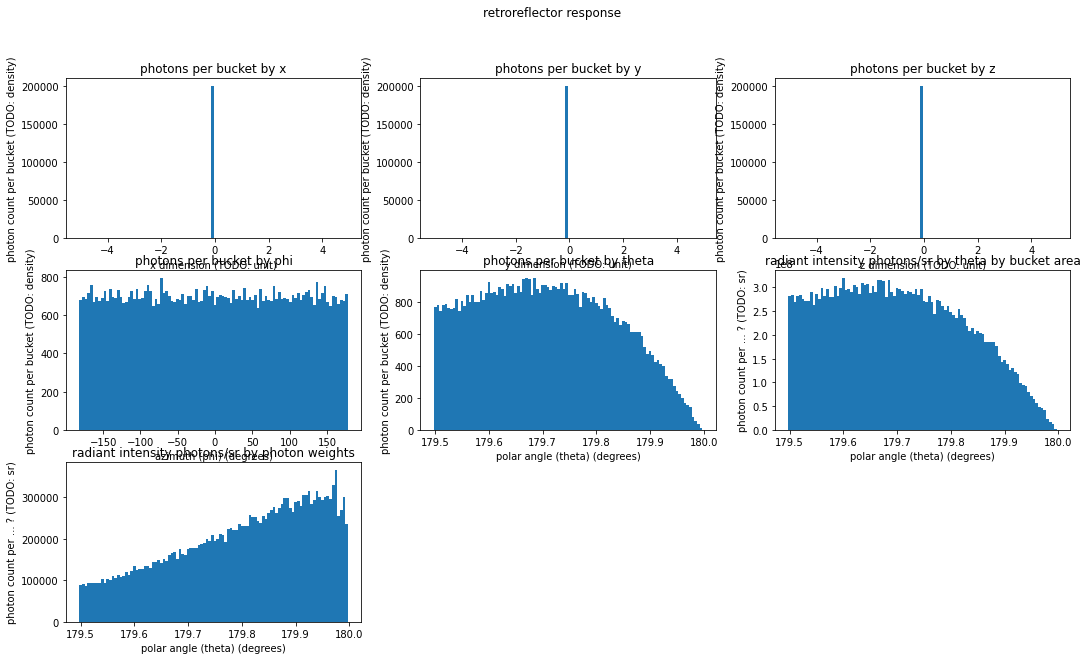

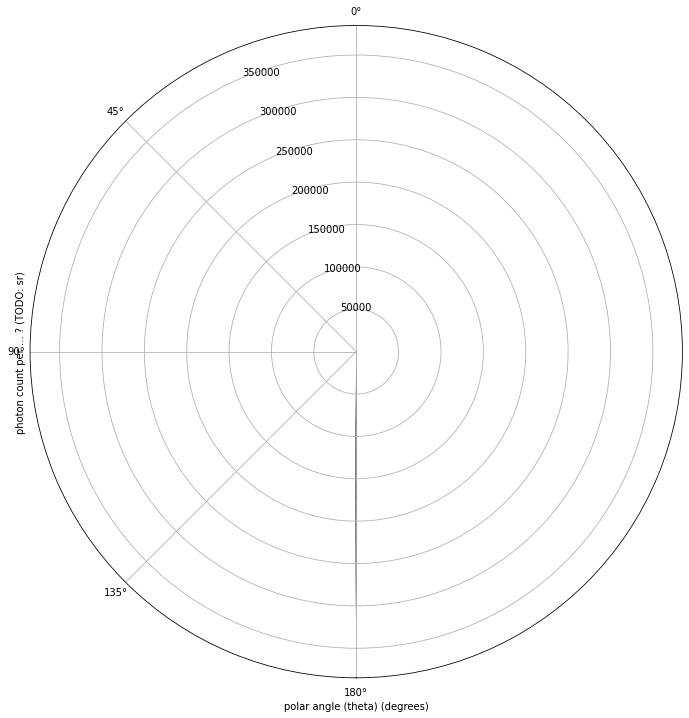

In [7]:
""" Show the intensity plot for the reflector.

FRC uses 3M Scotchlite, which has a reflection coefficient, R_A, of 500 at 0.2 degrees.
"""
def verify_reflector():
    photons = PencilSource().make_photons(200000) # pretty high resolution
    reflector = Diffuser(g = -0.9925, absorption = 0)
    reflector.diffuse(photons)

    plot_histogram_slices(photons, "retroreflector response", x_min=-5, x_max=5, y_min=-5, y_max=5, z_min=-5, z_max=5, theta_min=179.5*np.pi/180, theta_max=np.pi, bins=100)

verify_reflector()

# Simulation

In [8]:
""" Generate some photons from the LED.

For now use Lambertian, it's pretty close.
TODO: use the Cree distribution
Say the units are like 100 microns?  so like 1mm square?
TODO: calibrate the size
TODO: calibrate the output
"""
###
photon_count = 10000000
source_size = 10
source_box = [-source_size/2, source_size/2, -source_size/2, source_size/2, 0]
###
photons = LambertianSource(source_size, source_size).make_photons(photon_count)

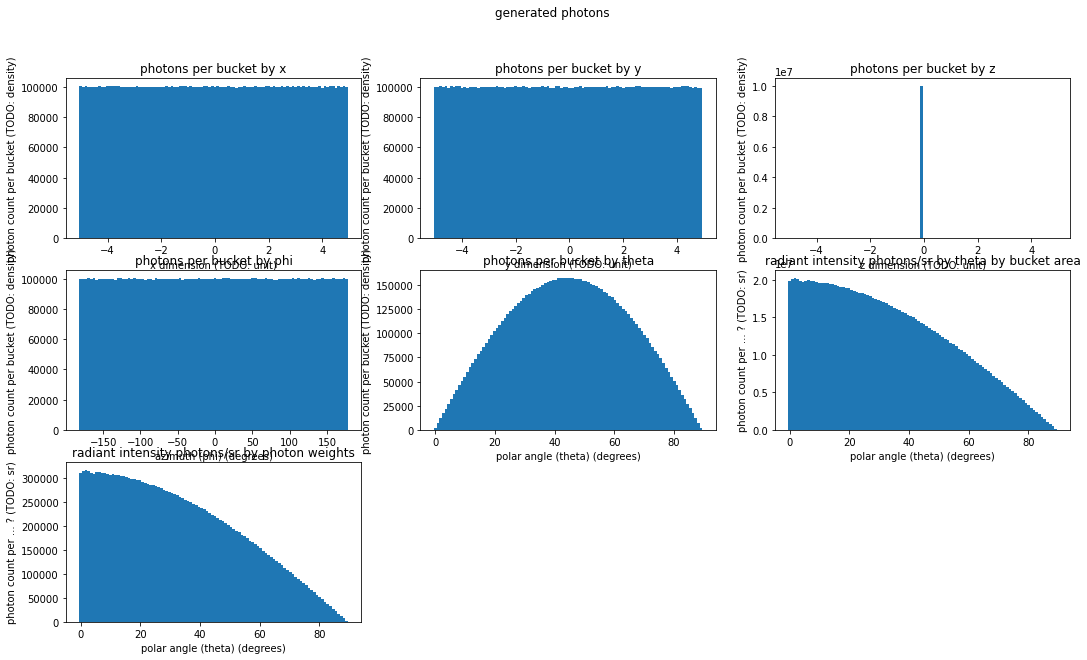

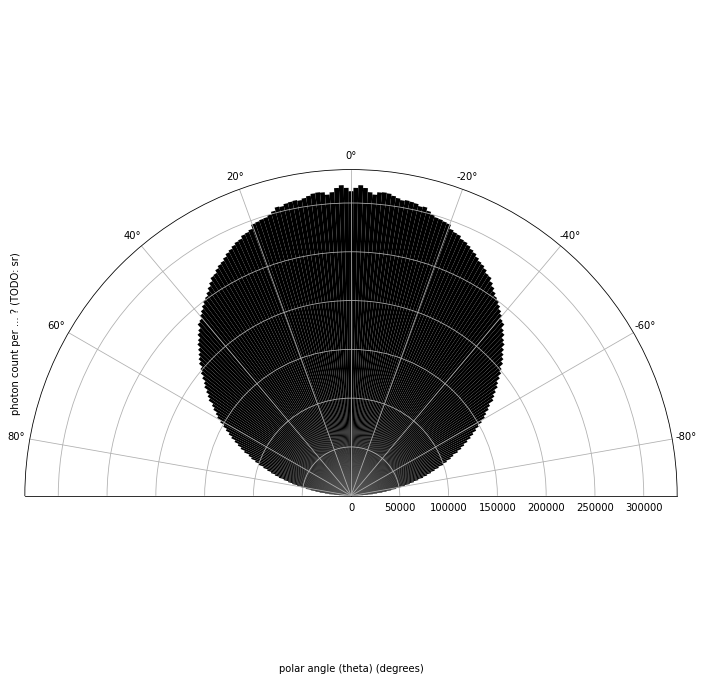

In [9]:
""" Look at the distributions of the generated photons."""
plot_histogram_slices(photons, "generated photons", -source_size/2, source_size/2, -source_size/2, source_size/2, z_min=-5, z_max=5, theta_max = np.pi/2)

/home/joel/OPTICS/SIM/optic-sim/viz.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection="3d")


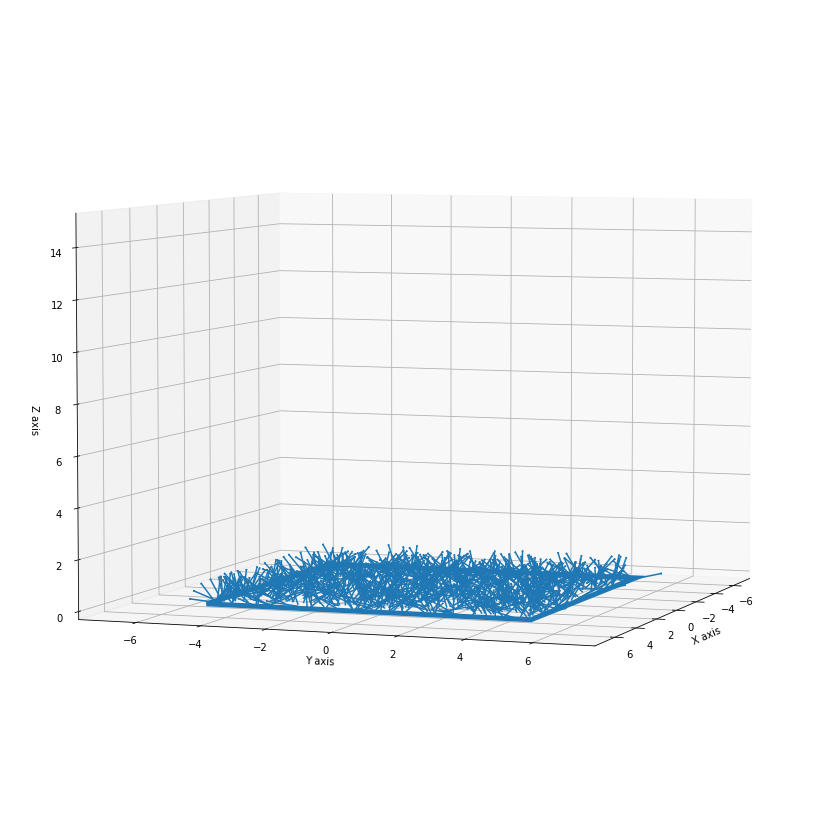

In [10]:
"""Look at the photons in 3d."""
photons_viz = Photon.sample(photons, 1000)
plot_rays([photons_viz], 5, 20, 15, 1, rectangles=[source_box])

In [11]:
""" Propagate the photons to the diffuser.

Most arrive at the diffuser surface.
Some are absorbed by the imperfectly reflective lightbox.
A square profile (or undersquare) helps keep the intensity even at the top. 
"""
###
lightbox_height = 400
lightbox_size = 400
lightbox_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height]
###

print(f"LED emitted photons: {Photon.countAlive(photons)}")
lightbox = Lightbox(height = lightbox_height, size = lightbox_size)
lightbox.propagate(photons)
print(f"diffuser incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")

LED emitted photons: 10000000
diffuser incident photons: 8448324
alive photons: 8448324


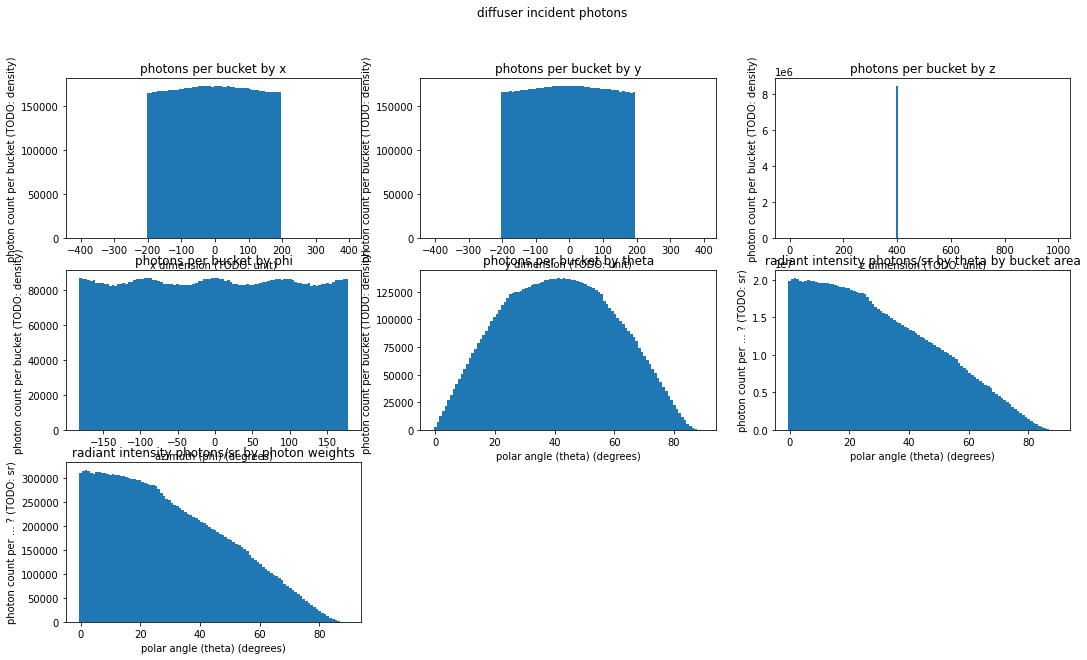

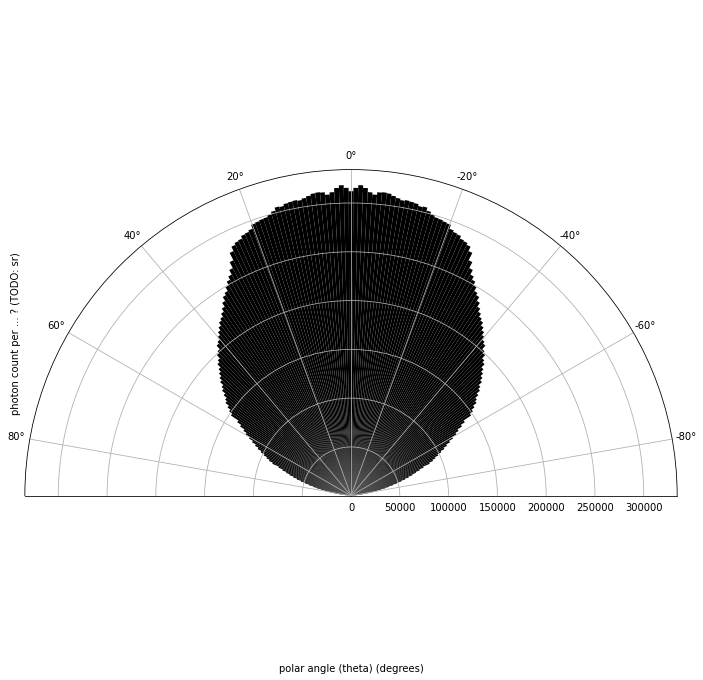

In [12]:
""" Show distributions of diffuser incident photons."""
plot_histogram_slices(photons, "diffuser incident photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=1000, theta_max = np.pi/2)

In [13]:
""" Diffuse through the diffuser. """
print(f"diffuser-incident photons: {Photon.countAlive(photons)}")
diffuser = Diffuser(g = 0.64, absorption = 0.16)
diffuser.diffuse(photons)
print(f"diffuser-transmitted photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
diffused_photons_viz = Photon.sample(photons, 1000)

diffuser-incident photons: 8448324
diffuser-transmitted photons: 7095374
alive photons: 7095374


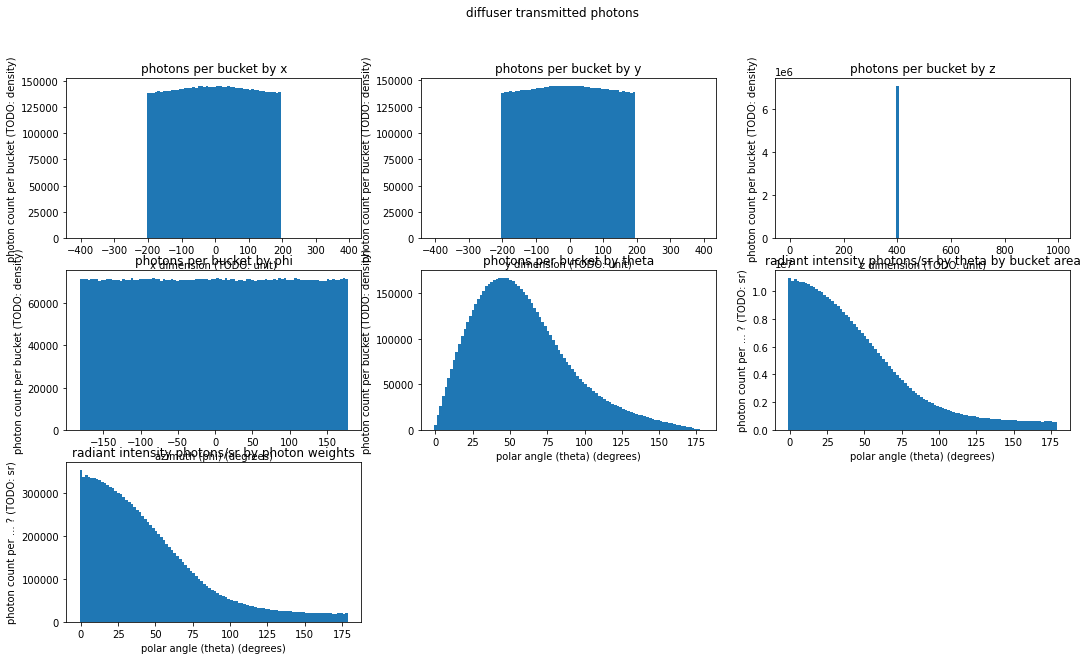

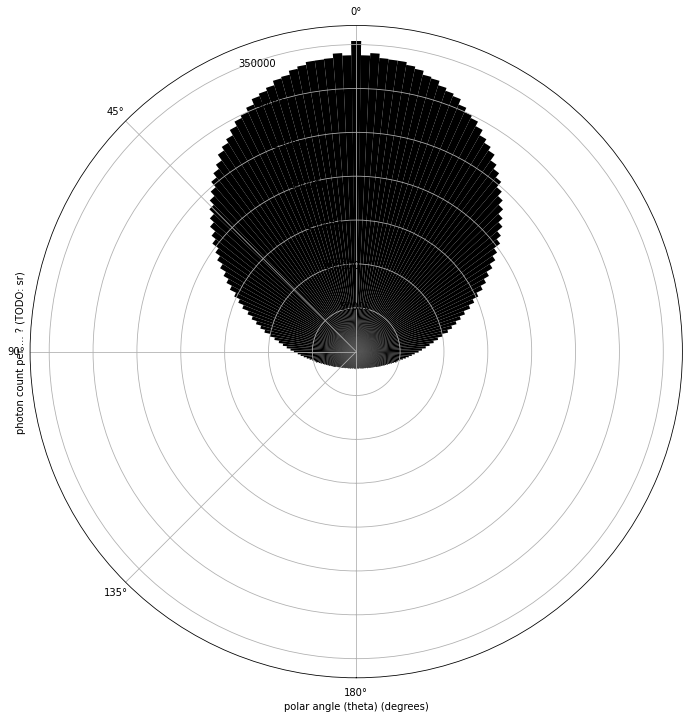

In [14]:
""" Show the distributions of photons transmitted by the diffuser.

Notice the distribution goes all the way to 180 degrees, a small fraction
of the incident photons are scattered downward.
"""
plot_histogram_slices(photons, "diffuser transmitted photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=1000)

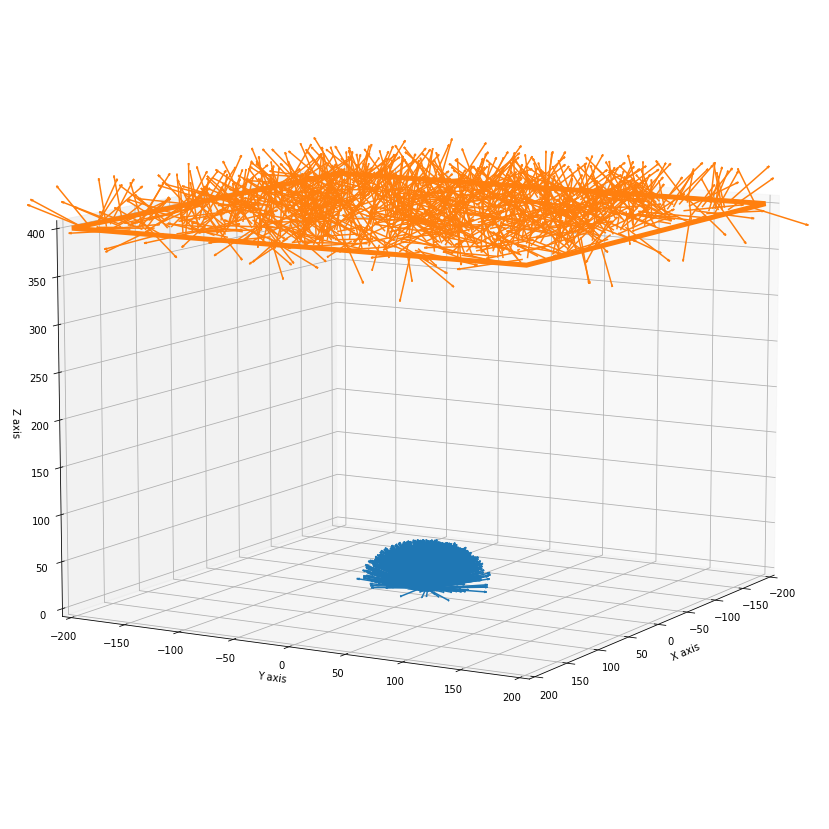

In [15]:
""" Show the LED-produced and diffuser-transmitted photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz], elev = 10, azim = 30, size = max(lightbox_height, lightbox_size), arrow_length = 50,
          rectangles=[source_box, lightbox_box])

In [16]:
""" Propagate diffuser-transmitted photons to the (far away) reflector. """
# min distance might be ... 10000 = 1 meter?  maybe less?
# max distance is probably ~100000 = 10 meters
# size might be 10cm square?
###
reflector_distance = 100000 # 1 m
reflector_box = [-500, 500, -500, 500, reflector_distance]
###
print(f"diffuser-transmitted photons: {Photon.countAlive(photons)}")
propagateToReflector(photons, location = reflector_distance, size = 1000)
print(f"reflector-incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
photons_at_reflector_viz = Photon.sample(photons, 1000)

diffuser-transmitted photons: 7095374
reflector-incident photons: 192
alive photons: 192


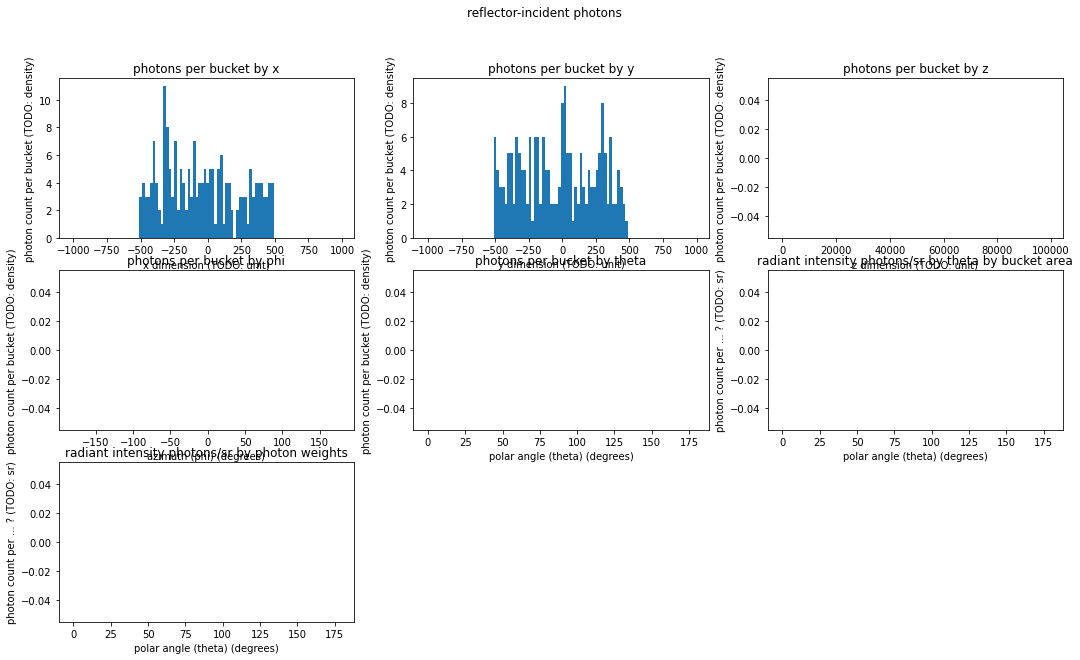

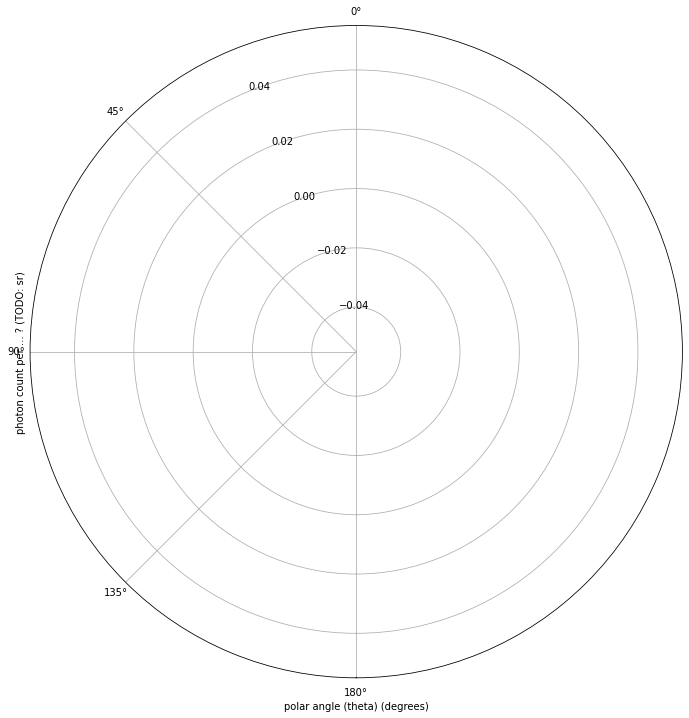

In [17]:
""" Show the distributions of reflector-incident photons """
plot_histogram_slices(photons, "reflector-incident photons", x_min=-1000, x_max=1000, y_min=-1000, y_max=1000, z_min=0, z_max=reflector_distance)

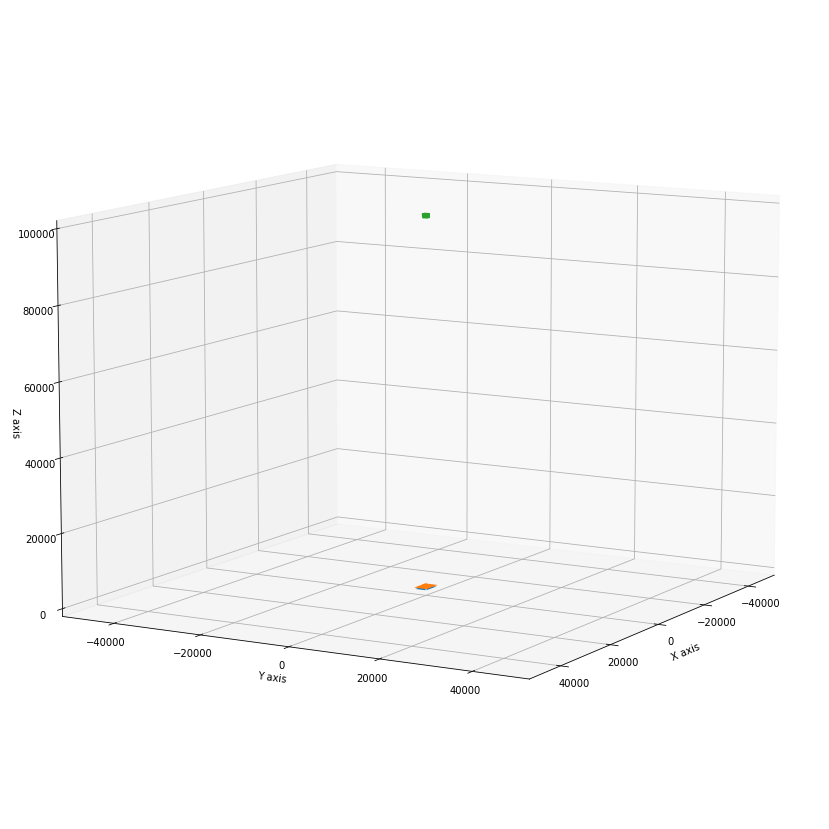

In [18]:
""" Show the generated, diffuser-transmitted, and reflector-incident photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz, photons_at_reflector_viz ], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 500,
          rectangles=[source_box, lightbox_box, reflector_box])

In [19]:
""" Reflect the incident photons at the reflector. """
print(f"reflector-incident photons: {Photon.countAlive(photons)}")
reflector = Diffuser(g = -0.9925, absorption=0.0)
reflector.diffuse(photons)
print(f"reflected photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
reflected_photons_viz = Photon.sample(photons, 1000)

reflector-incident photons: 192
reflected photons: 192
alive photons: 192


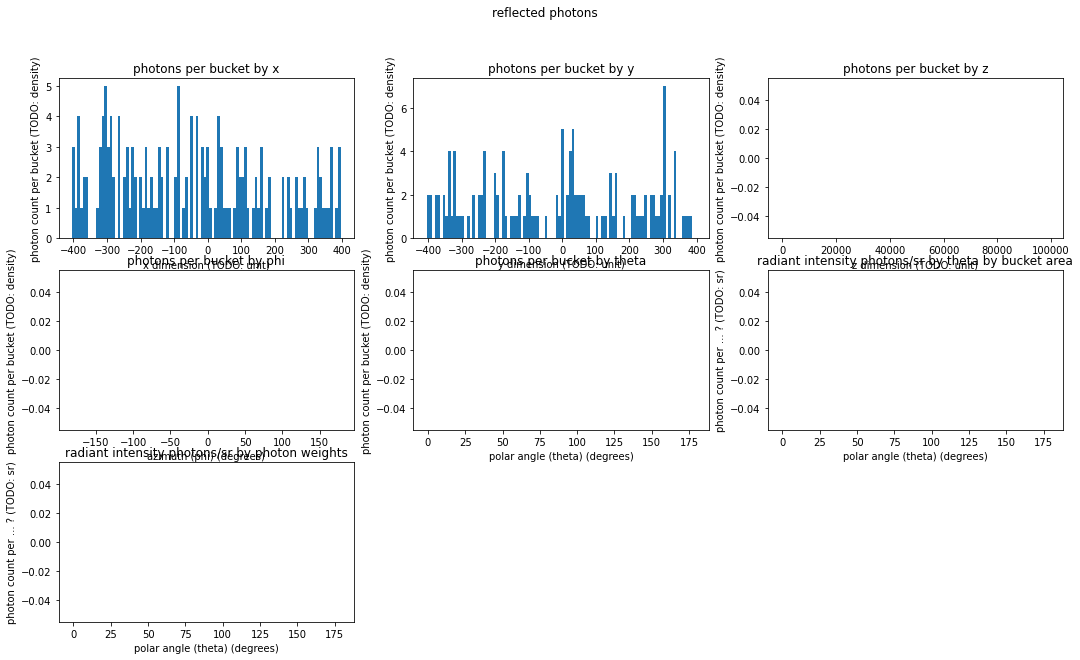

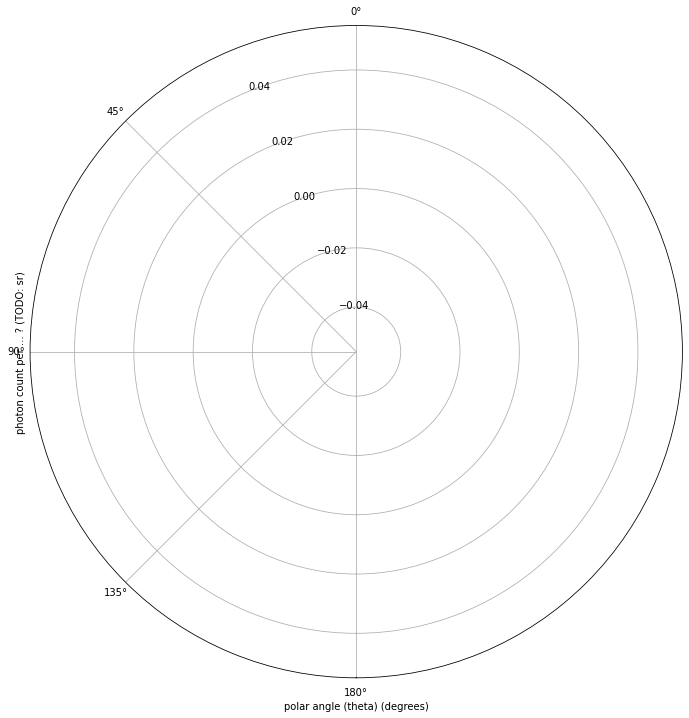

In [20]:
""" Show the distributions of reflected photons """
plot_histogram_slices(photons, "reflected photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=reflector_distance)

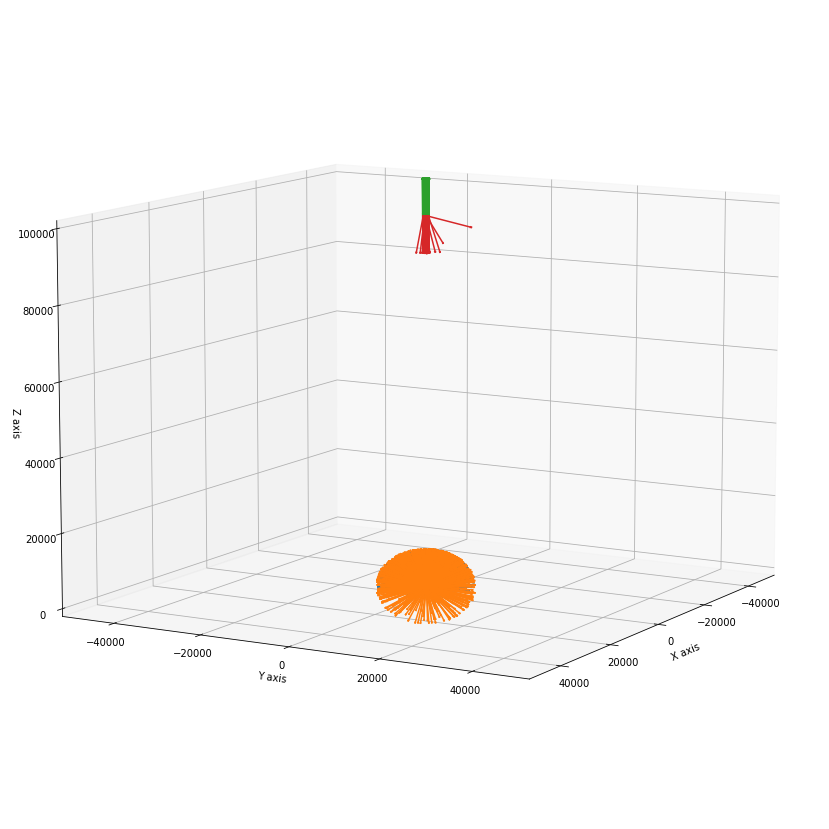

In [21]:
""" Show the generated, transmitted, reflector-incident and reflected photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz, photons_at_reflector_viz, reflected_photons_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

In [22]:
""" Propagate the reflected photons to the camera plane. """
print(f"reflected photons: {Photon.countAlive(photons)}")
propagateToCamera(photons, location = lightbox_size) # make the camera height even with the diffuser
print(f"camera-incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
photons_at_camera_plane_viz = Photon.sample(photons, 1000)

reflected photons: 192
camera-incident photons: 192
alive photons: 192


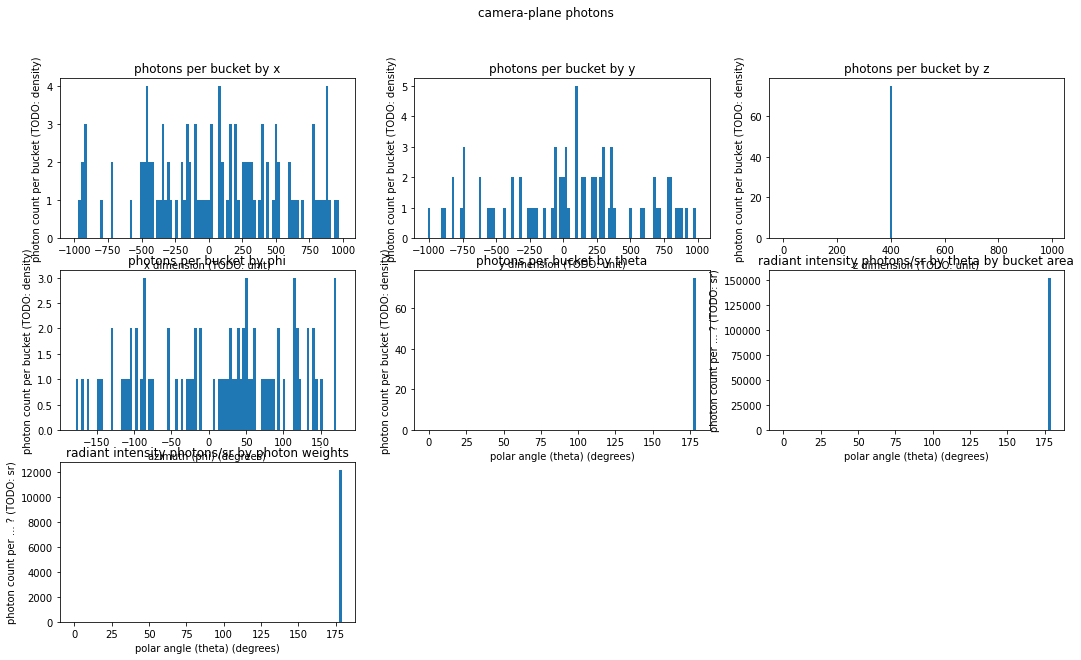

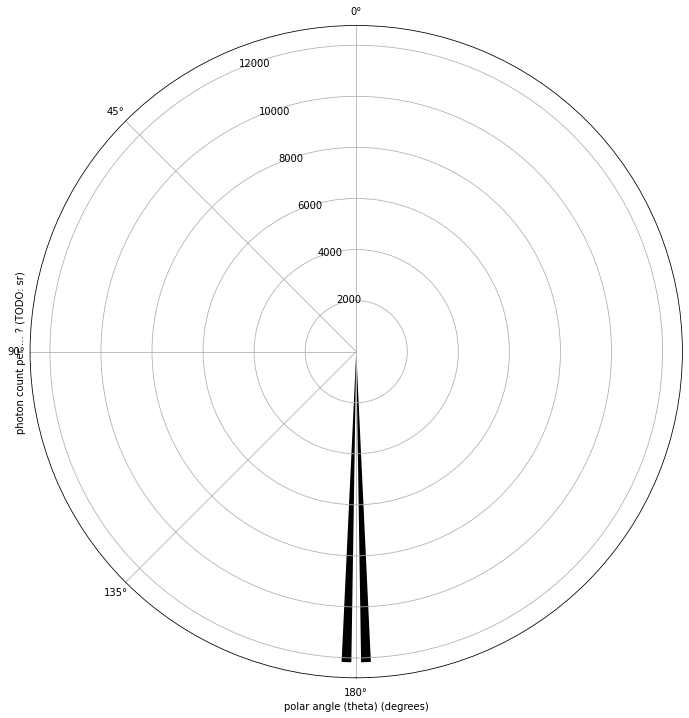

In [23]:
""" Show the distributions of camera-plane photons """
plot_histogram_slices(photons, "camera-plane photons", x_min=-1000, x_max=1000, y_min=-1000, y_max=1000, z_min=0, z_max=1000)

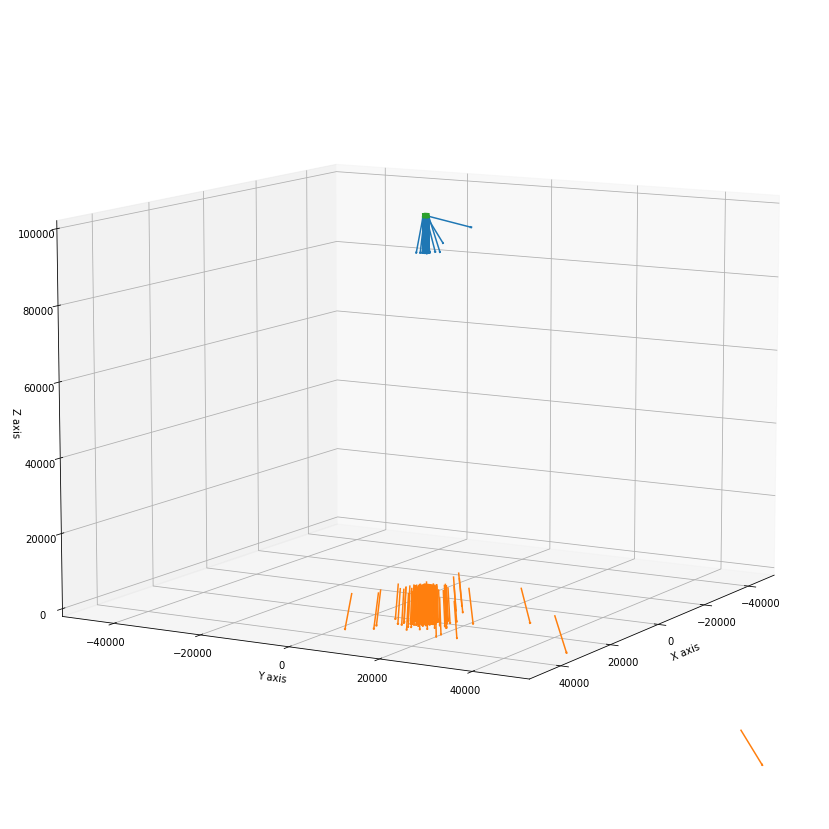

In [24]:
""" Show the reflected photons in 3d."""
plot_rays([reflected_photons_viz, photons_at_camera_plane_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

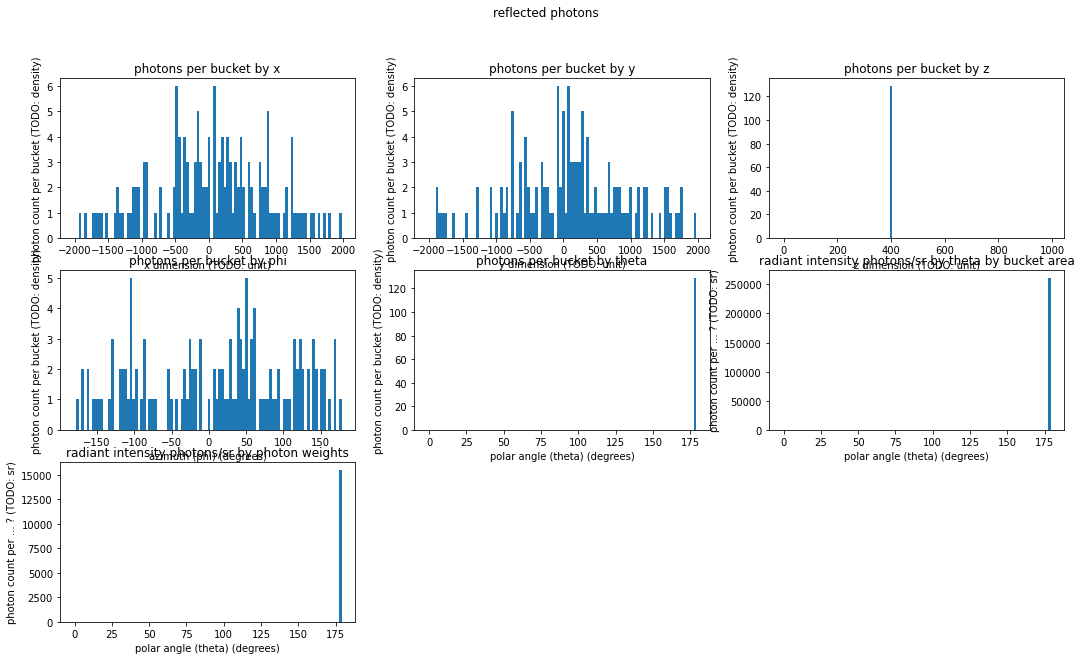

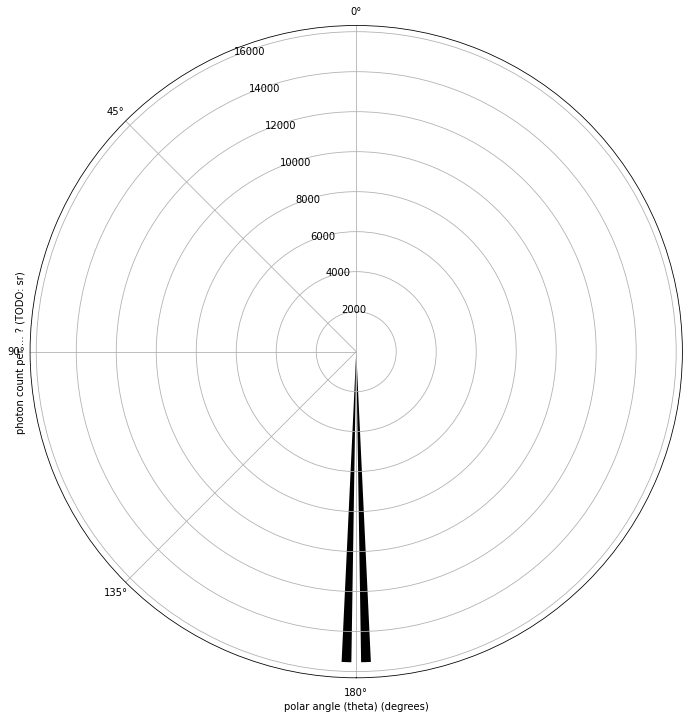

In [25]:
""" Show the distributions of reflected photons, close up """
plot_histogram_slices(photons, "reflected photons", x_min=-2000, x_max=2000, y_min=-2000, y_max=2000, z_min=0, z_max=1000)

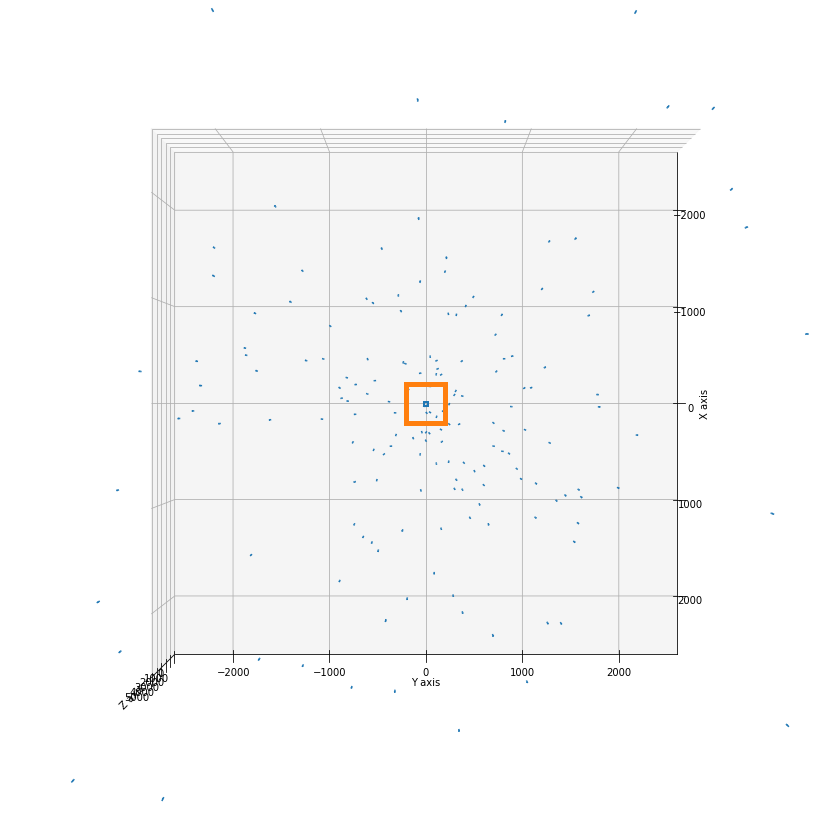

In [26]:
""" Look closer at the neighborhood of the detector. """
plot_rays([photons_at_camera_plane_viz], 
          elev = 90, azim = 0, size = 5000, arrow_length = 1000,
          rectangles=[source_box, lightbox_box])